# Fourier Transforms

Fourier transforms convert from periodic functions (in our case, periodic in time or space) to a Fourier series of orthogonal sine and cosine functions:

\begin{equation*}
    a(t) = \frac{1}{2}a_0 + \sum_{n=1}^{\infty}(c_n cos(n{\omega}t) + s_n sin(n{\omega}t))
\end{equation*}

When s<sub>n</sub> and c<sub>n</sub> are Fourier coefficients.

In seismology we use the Fourier transform to convert from the time domain to the frequency domain. Because we are dealing with digital data (discretely 
sampled) we make use of the discrete Fourier transform (DFT). We will often refer to the Fast Fourier transform (FFT) as well, which is an efficient computational
implementation of the DFT. The Fourier transform allows us to study the frequencies that make up our seismogram - we will make use of this when computing
magnitudes and thinking about earthquake source processes.  Over longer time-series we can also look at the the frequencies of various normal modes of the earth.

One of the most common uses for the Fourier transform in seismology is when filtering seismograms.  Filters work as convolutions in the time domain, or
multiplications in the frequency domain.  Because multiplication is more computationally efficient than convolution, filtering is commonly done in the
frequency domain.  Of key importance here is that we can convert back from the frequency domain to the time domain using the inverse Fourier transform
(IFT).

In this notebook we will look at the Fourier spectrums of a few different signals - we will also play with decimating our data in the same way that we did in
the [digitizers notebook](2_Digitizers.ipynb).

Note: Discrete Fourier transforms assume that the data can be represented by periodic functions, thus the data that you are transforming is assumed to be periodic and must start and end at the same value to allow wraparound.  One way that we cope with this in seismology is to detrend our data (so that the start and end are zero).

In [1]:
# Set up notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from obspy import read
plt.style.use('ggplot')


def plot_fft(x, y, dt):
    """
    Calculate the FFT of a discretely sampled series and plot the spectra.
    
    :type y: `numpy.ndarray`
    :param y: Series to calculate FFT for.
    :type dt: float
    :param dt: 
        Sample interval - assumed to be in seconds, so frequencies in Hz.
    """
    from scipy import fftpack
    import warnings
    

    
    N = len(y)
    fft_len = fftpack.next_fast_len(N)  # Find the next fast length for the FFT
    yf = fftpack.fft(y, n=fft_len)
    xf = np.linspace(0.0, 1.0 / (2. * dt), int(N / 2))
    yr = fftpack.ifft(yf)
    
    fig, ax = plt.subplots(nrows=3, figsize=(15, 8))
    ax[0].plot(x, y, label="Time series")
    ax[0].set_xlabel("Time (s)")
    ax[0].autoscale(enable=True, axis='both', tight=True)
    ax[0].legend()
       
    ax[1].loglog(xf, 2./N * np.abs(yf[:N//2]), label="Frequency spectra")
    ax[1].set_xlabel("Frequency (Hz)")
    ax[1].autoscale(enable=True, axis='both', tight=True)
    ax[1].legend()
    
    ax[2].plot(x, np.real(yr), label="Reconstructed Time-series")
    ax[2].set_xlabel("Time (s)")
    ax[2].autoscale(enable=True, axis='both', tight=True)
    ax[2].legend()

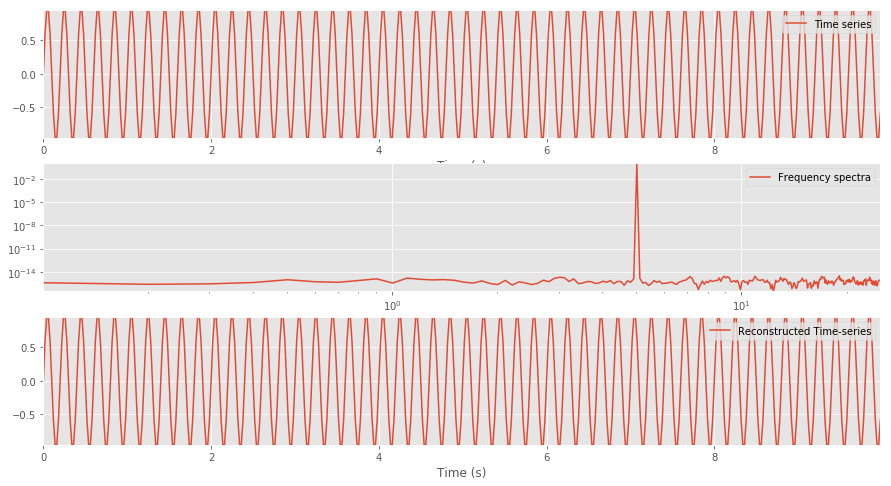

In [2]:
sample_frequency = 50
dt = 1 / sample_frequency
sine_freq = 5
x = np.arange(0.0, 50 * (1 / sine_freq), dt)
y = np.sin(x * sine_freq * 2 * np.pi)

plot_fft(x, y, dt)

With this simple sine curve we get a nice clear peak in the frequency spectra at the frequency of the input sine curve.

Lets try adding in a second, higher frequency since curve and see what that looks like.

**Exercise:** Try adding another different sine wave of a similar frequency and see if you can resolve it in the
frequency domain. Also note what happens when two similar sine-waves are summed - beating modulations.

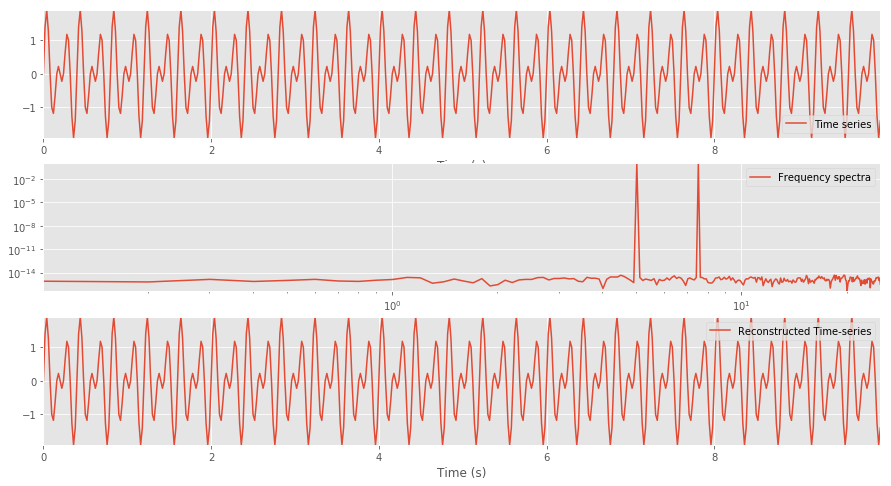

In [3]:
second_sine_freq = 7.5

y_2 = y + np.sin(x * second_sine_freq * 2 * np.pi)

plot_fft(x, y_2, dt)

Now lets try some real data.

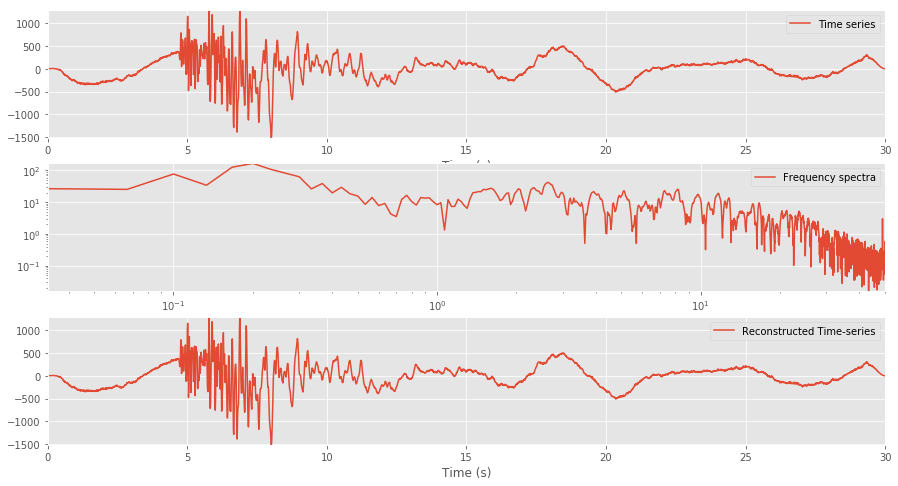

In [4]:
tr = read()[0]
x = np.arange(0, tr.stats.npts * tr.stats.delta, tr.stats.delta)
y = tr.data

plot_fft(x, y, tr.stats.delta)

**Question:** What is the dominant frequency here?

You can see it in the raw data - this background low-frequency energy is often related to the 
Earth's noise microseisms. Also note that the amplitude of the frequency spectra falls off with
increasing frequency. We will use this later to estimate moment magnitude.

Lets see what our spectra looks like when we decimate our seismic data.

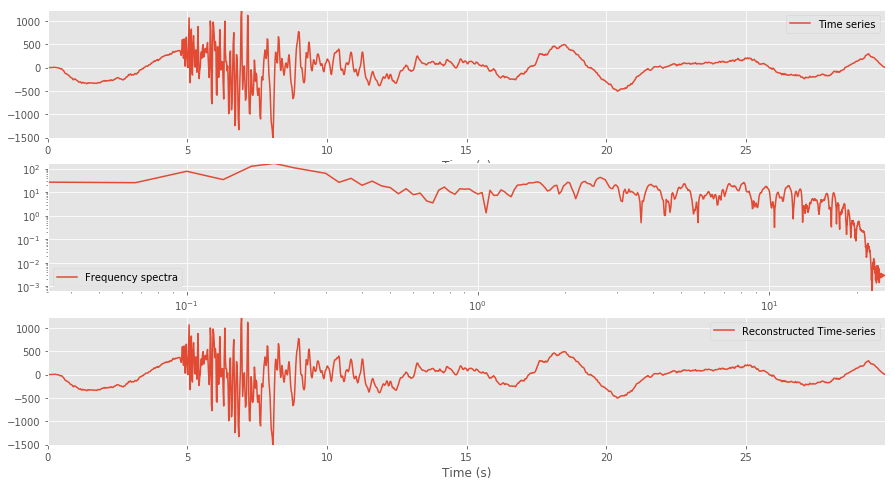

In [5]:
tr.decimate(2)

x = np.arange(0, tr.stats.npts * tr.stats.delta, tr.stats.delta)
y = tr.data

plot_fft(x, y, tr.stats.delta)

**Exercise:** Play around with other sine-waves, and decimation factors.  What do you see happening to the spectra of the decimated seismogram?

## Gibb's phenomenon

Because we are using a DFT (Discrete Fourier Transform), which uses only a finite number of terms to
describe the frequency content, we are susceptible to Gibb's phenomenon. Gibb's phenomemon occurs where
there are discontinuities in the time-series (or equally, when there are discontinuities in the
spectrum).  A disconinuity (e.g. something like a step) cannot to represented accurately with a 
finite number of sine waves: a step in the time-domain contains infinite frequencies.  The oscillations
associated with the overshoot of sine-waves is known as Gibb's phenomenon.

In the below example we artificially introduce a step into the previous time-series. Note that
this step offset also introduces a step at the start and end of the time-series because the
Fourier transform assumes the signal is periodic.  We see that our frequency spectra "rings",
constantly returning to an almost flat spectrum up to the Nyquist.

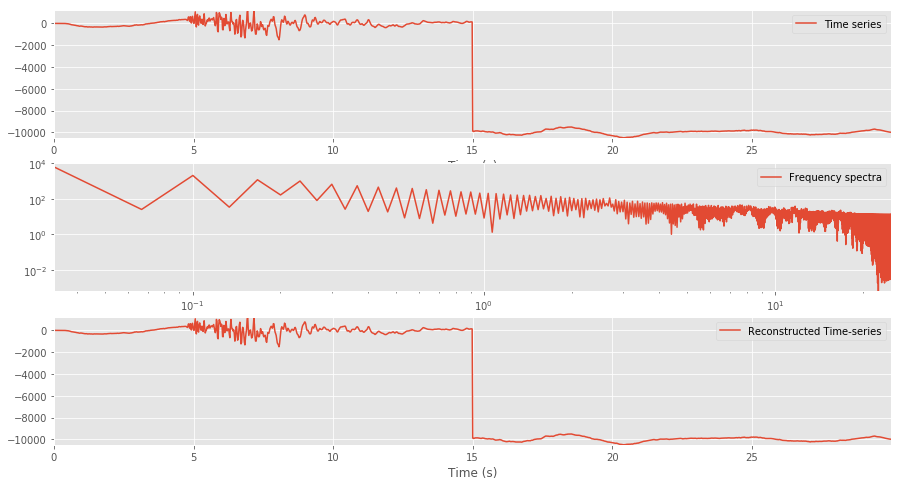

In [6]:
step_position = int(tr.stats.npts / 2)
x = np.arange(0, tr.stats.npts * tr.stats.delta, tr.stats.delta)
tr_stepped = tr.copy()
tr_stepped.data[step_position:] -= 1e4
y = tr_stepped.data

plot_fft(x, y, tr.stats.delta)

Similarly, if we generate a frequency spectrum with a step in it, the time-series generated by the
inverse Fourier transform will ring:

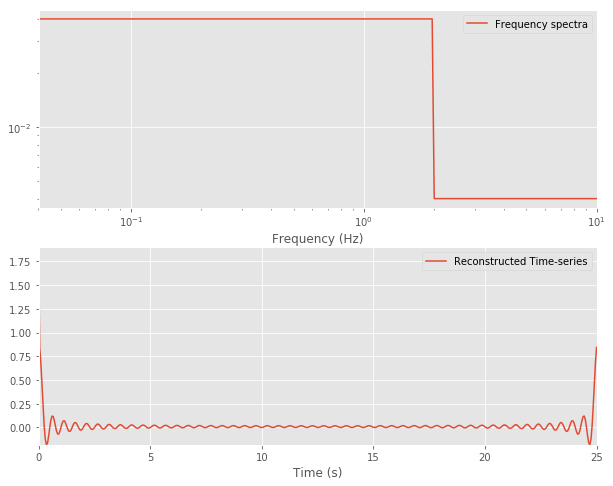

In [7]:
from scipy import fftpack
N = 500
dt = 0.05
step_position = 2  # Step position in Hz

# Make the steped frequency spectra
yf = np.ones(N) * 10
nyquist = 1 / (2. * dt)
if step_position >= nyquist:
    raise NotImplementedError(
        "Step should be below nyquist: {0}".format(nyquist))
freq_interval = nyquist / int(N / 2)
step_location = int(step_position / freq_interval)
yf[step_location:] = np.ones_like(yf[step_location:])
xf = np.linspace(0.0, 1.0 / (2. * dt), int(N / 2))

# Do the ifft
yr = fftpack.ifft(yf)
x = np.linspace(0.0, N * dt, N)

# Plot
fig, ax = plt.subplots(nrows=2, figsize=(10, 8))
ax[0].loglog(xf, 2./N * np.abs(yf[:N//2]), label="Frequency spectra")
ax[0].set_xlabel("Frequency (Hz)")
ax[0].autoscale(enable=True, axis='x', tight=True)
ax[0].legend()

ax[1].plot(x, np.real(yr), label="Reconstructed Time-series")
ax[1].set_xlabel("Time (s)")
ax[1].autoscale(enable=True, axis='both', tight=True)
_ = ax[1].legend()

You will note that there are lots of oscillations at the start and end of the time-series.

**Exercise:** Try playing with the length of the Fourier transform (N) and see what it does 
to the ringing - what happens as you increase N and why do you think this happens? What do
you think that means for the accuracy of Fourier transforms of short seismic data?  

Hint, you need long time-series to accuretely represent long-period waves like the Earth's
normal modes.

## Conclusion
That is it for this notebook - hopefully this has provided you with some tools to examine time-series
data in the frequency domain, and shown you that we can transfer to and from the frequency domain
using the FFT and iFFT.

In the [next notebook](4_Filtering_Resampling.ipynb) we will look at how we filter seismic data and what effect this has on the sepctra.